In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
#task 1
import requests
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY_ADJUSTED&symbol=CF&apikey=WICXD5CVC1GOEE3F&datatype=json'
r = requests.get(url)
data = r.json()
print(data)

{'Meta Data': {'1. Information': 'Weekly Adjusted Prices and Volumes', '2. Symbol': 'CF', '3. Last Refreshed': '2023-12-01', '4. Time Zone': 'US/Eastern'}, 'Weekly Adjusted Time Series': {'2023-12-01': {'1. open': '77.6100', '2. high': '78.0100', '3. low': '73.8500', '4. close': '76.3100', '5. adjusted close': '76.3100', '6. volume': '15242235', '7. dividend amount': '0.0000'}, '2023-11-24': {'1. open': '77.6500', '2. high': '79.1400', '3. low': '74.0750', '4. close': '78.3600', '5. adjusted close': '78.3600', '6. volume': '10513632', '7. dividend amount': '0.0000'}, '2023-11-17': {'1. open': '79.3300', '2. high': '82.9900', '3. low': '77.4400', '4. close': '77.4600', '5. adjusted close': '77.4600', '6. volume': '9906381', '7. dividend amount': '0.4000'}, '2023-11-10': {'1. open': '81.0800', '2. high': '81.9000', '3. low': '77.9500', '4. close': '79.5300', '5. adjusted close': '79.1346', '6. volume': '9285162', '7. dividend amount': '0.0000'}, '2023-11-03': {'1. open': '80.5000', '2. h

In [ ]:
# Extracting the 'Weekly Adjusted Time Series' data
time_series_data = data['Weekly Adjusted Time Series']

# Assuming 'time_series_data' is your dictionary containing the data.
time_series_list = list(time_series_data.items())

# Convert string dates to datetime objects for accurate sorting.
time_series_list = [(pd.to_datetime(date), data) for date, data in time_series_list]

# Sort the list of tuples by the date (the first element of the tuple).
time_series_list.sort(key=lambda x: x[0])

# Now you can convert it back into a dictionary or create a DataFrame.
sorted_time_series_dict = {date.strftime('%Y-%m-%d'): data for date, data in time_series_list}

# If you want to work with a DataFrame:
sorted_df = pd.DataFrame.from_dict(sorted_time_series_dict, orient='index')
sorted_df.columns = ['open', 'high', 'low', 'close', 'adjusted close', 'volume', 'dividend amount']

# Converting data types from string to float
for col in sorted_df.columns:
    sorted_df[col] = pd.to_numeric(sorted_df[col], errors='coerce')

sorted_df

,open,high,low,close,adjusted close,volume,dividend amount
2005-08-19,17.75,17.85,16.250,16.60,2.4029,7583500,0.0
2005-08-26,16.65,17.94,16.410,17.47,2.5288,5365900,0.0
2005-09-02,16.90,17.39,15.530,16.07,2.3262,5852100,0.0
2005-09-09,16.20,16.60,16.020,16.57,2.3986,2279400,0.0
2005-09-16,16.45,16.52,14.550,15.32,2.2176,4942700,0.0
...,...,...,...,...,...,...,...
2023-11-03,80.50,82.64,76.850,81.55,81.1445,10495373,0.0
2023-11-10,81.08,81.90,77.950,79.53,79.1346,9285162,0.0
2023-11-17,79.33,82.99,77.440,77.46,77.4600,9906381,0.4
2023-11-24,77.65,79.14,74.075,78.36,78.3600,10513632,0.0


In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(sorted_df)

X = []
y = []

for i in range(len(scaled_features) - 1):
    X.append(scaled_features[i])
    y.append(scaled_features[i + 1])

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)

In [ ]:
import tensorflow as tf

class CustomRNN(tf.Module):
    def __init__(self, size):
        # Initialize weights
        self.A = tf.Variable(tf.random.normal([size, size]), trainable=True)
        self.B = tf.Variable(tf.random.normal([size, size]), trainable=True)
        self.C = tf.Variable(tf.random.normal([size, size]), trainable=True)
        self.D = tf.Variable(tf.random.normal([size, size]), trainable=True)
        self.h = tf.Variable(tf.zeros([size]), trainable=False)

    def __call__(self, x):
        # Reshape h to match the matrix multiplication requirements
        h_reshaped = tf.reshape(self.h, [1, -1])

        # Compute ht+1
        ht_plus_1 = tf.nn.relu(tf.matmul(h_reshaped, self.A) + tf.matmul(x, self.B))
        self.h.assign(ht_plus_1[0])

        # Compute yt
        y = tf.matmul(ht_plus_1, self.C) + tf.matmul(x, self.D)
        return y

size = 7
model = CustomRNN(size)

tf.Tensor(
[[-1.0187862   0.65542996  1.8185358   2.331933   -0.64161694  2.364983
  -0.6724658 ]], shape=(1, 7), dtype=float32)


In [ ]:
# Define the loss function
def loss_fn(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true))

# Initialize the Adam optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Training loop
def train_step(model, inputs, outputs):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_fn(predictions, outputs)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Assuming X_train and y_train are already defined and preprocessed
# Example training loop for one epoch
for epoch in range(num_epochs):
    epoch_loss = 0
    for i in range(len(X_train) - 1):
        input_x = tf.convert_to_tensor([X_train[i]], dtype=tf.float32)
        true_y = tf.convert_to_tensor([y_train[i + 1]], dtype=tf.float32)

        loss = train_step(model, input_x, true_y)
        epoch_loss += loss.numpy()

    epoch_loss /= len(X_train) - 1
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')

Epoch 1, Loss: 4194791012.4272017
Epoch 2, Loss: 136.5630844649211
Epoch 3, Loss: 128.27322021862028
Epoch 4, Loss: 163.65387096954143
Epoch 5, Loss: 163.74176588083503
Epoch 6, Loss: 117.87390505927284
Epoch 7, Loss: 179.5663612363689
Epoch 8, Loss: 149.99082768057275
Epoch 9, Loss: 114.90847518766333
Epoch 10, Loss: 117.08544886346877
Epoch 11, Loss: 152.33037139397123
Epoch 12, Loss: 111.68835288608872


In [ ]:
# Plotting function
def plot_history(histories, key='mae'):
    plt.figure(figsize=(15,5))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

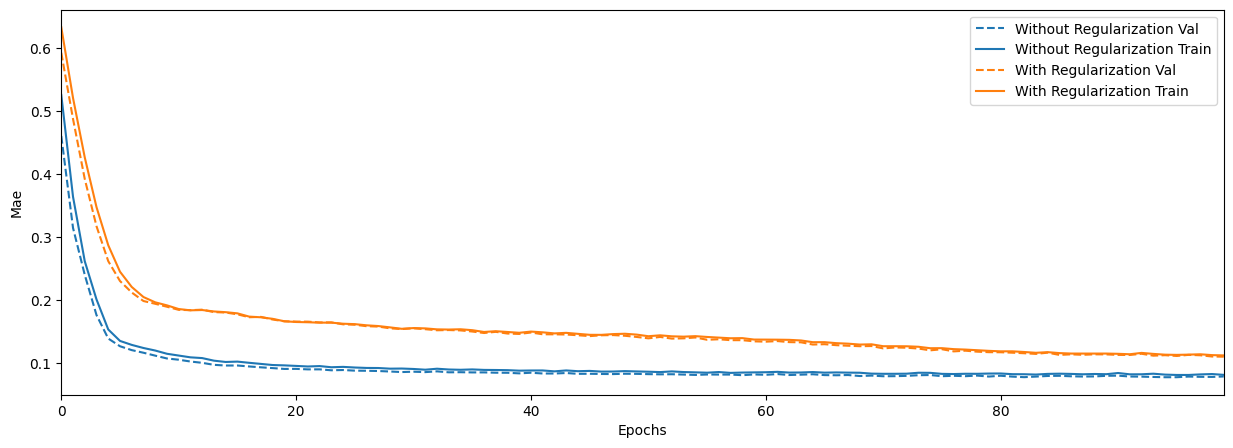

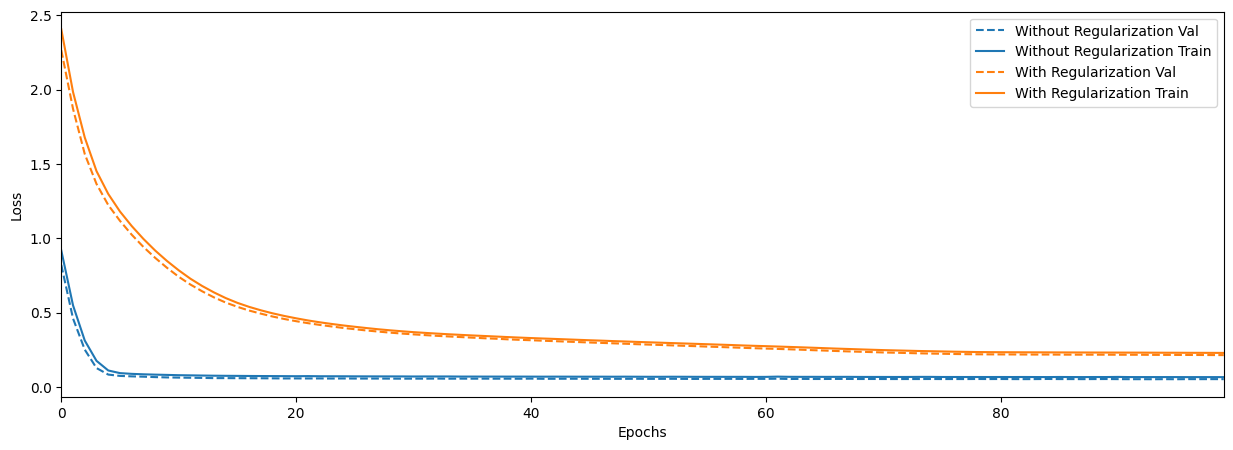

In [ ]:
# Plot the results
plot_history([('without regularization', history_without_reg),
              ('with regularization', history_with_reg)],
             key='mae')
plot_history([('without regularization', history_without_reg),
              ('with regularization', history_with_reg)],
             key='loss')